# Forecasting Net Prophet

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/about-us). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

The instructions for this Challenge are divided into four steps, as follows:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

The following subsections detail these steps.

## Install and import the required libraries and dependencies

In [ ]:
# Install the required libraries
!pip install prophet

In [12]:
# Import the required libraries and dependencies
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

To do so, complete the following steps:

1. Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

2. Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?


#### Step 1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

In [5]:
# Store the data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.

df_mercado_trends = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv",
    index_col='Date',
    parse_dates=True
).dropna()

# Review the first and last five rows of the DataFrame
display(df_mercado_trends.head())
display(df_mercado_trends.tail())

<ipython-input-5-217fb1a948ac>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mercado_trends = pd.read_csv(


,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38


,Search Trends
Date,
2020-09-07 20:00:00,71
2020-09-07 21:00:00,83
2020-09-07 22:00:00,96
2020-09-07 23:00:00,97
2020-09-08 00:00:00,96


from matplotlib import pyplot as plt
_df_4['Search Trends'].plot(kind='hist', bins=20, title='Search Trends')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5['Search Trends'].plot(kind='line', figsize=(8, 4), title='Search Trends')
plt.gca().spines[['top', 'right']].set_visible(False)

In [6]:
# Review the data types of the DataFrame using the info function
df_mercado_trends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00 to 2020-09-08 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 579.8 KB


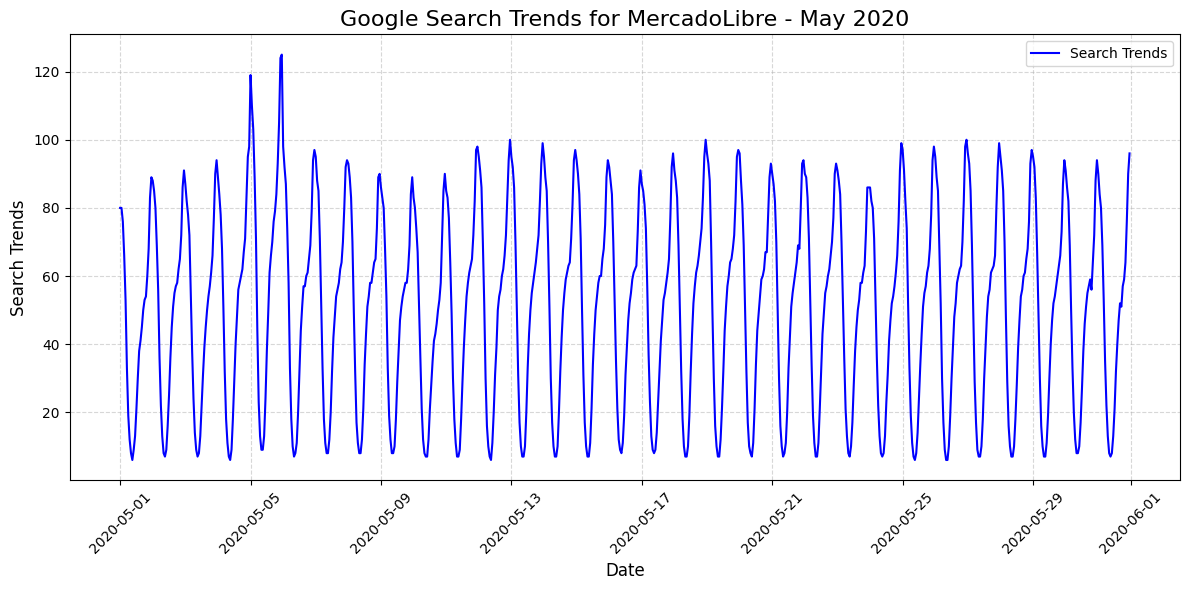

In [13]:
# Slice the DataFrame to just the month of May 2020
df_may_2020 = df_mercado_trends.loc['2020-05-01':'2020-05-31']

# Plot to visualize the data for May 2020
plt.figure(figsize=(12, 6))
plt.plot(df_may_2020.index, df_may_2020['Search Trends'], label='Search Trends', color='blue')
plt.title('Google Search Trends for MercadoLibre - May 2020', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Search Trends', fontsize=12)
plt.xticks(rotation=45)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

#### Step 2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?

In [14]:
# Calculate the sum of the total search traffic for May 2020
traffic_may_2020 = df_may_2020['Search Trends'].sum()

# View the traffic_may_2020 value
print(traffic_may_2020)


38181


In [15]:
# Calculate the monthly median search traffic across all months
# Group the DataFrame by index year and then index month, chain the sum and then the median functions
median_monthly_traffic = (
    df_mercado_trends.resample('M')  # Resample by month to aggregate data monthly
    .sum()                           # Sum the search trends for each month
    .median()                        # Calculate the median across all months
)

# View the median_monthly_traffic value
print(median_monthly_traffic)

Search Trends    35172.5
dtype: float64


<ipython-input-15-95f452ae5c15>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_mercado_trends.resample('M')  # Resample by month to aggregate data monthly


In [16]:
# Compare the seach traffic for the month of May 2020 to the overall monthly median value
traffic_may_2020/median_monthly_traffic

,0
Search Trends,1.085536


##### Answer the following question:

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results?

**Answer:** Yes, Google search traffic increased about 8.5% during May, 2020.

## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company. To do so, complete the following steps:

1. Group the hourly search data to plot the average traffic by the hour of day. Does the search traffic peak at a particular time of day or is it relatively consistent?

2. Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday). Does the search traffic get busiest on any particular day of the week?

3. Group the hourly search data to plot the average traffic by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?


#### Step 1: Group the hourly search data to plot the average traffic by the hour of the day.

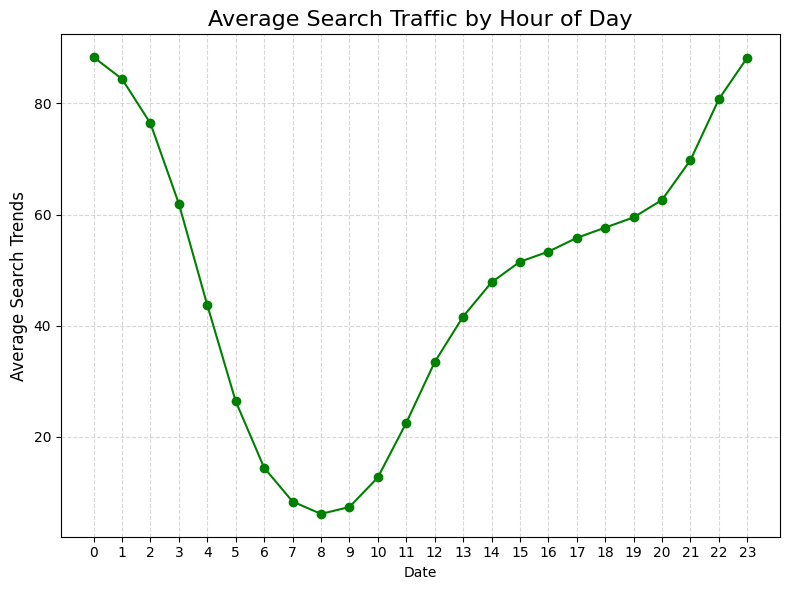

In [22]:
# Group the hourly search data by the hour of the day and calculate the average traffic
hourly_average_traffic = df_mercado_trends.groupby(df_mercado_trends.index.hour).mean()

# Plot the average search traffic by hour of the day
plt.figure(figsize=(8, 6))
plt.plot(hourly_average_traffic.index, hourly_average_traffic['Search Trends'], marker='o', linestyle='-', color='green')
plt.title('Average Search Traffic by Hour of Day', fontsize=16)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Average Search Trends', fontsize=12)
plt.xticks(np.arange(0, 24, 1))  # Set x-axis ticks for each hour
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


#### Step 2: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

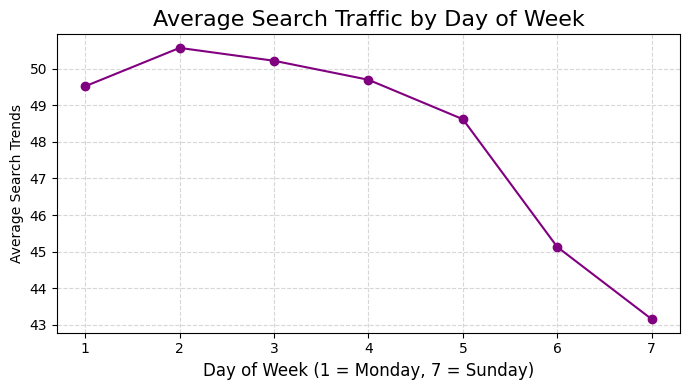

In [25]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.isocalendar().day`.
daily_average_traffic = df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().day).mean()

# Plot the average search traffic by day of the week
plt.figure(figsize=(7, 4))
plt.plot(daily_average_traffic.index, daily_average_traffic['Search Trends'], marker='o', linestyle='-', color='purple')
plt.title('Average Search Traffic by Day of Week', fontsize=16)
plt.xlabel('Day of Week (1 = Monday, 7 = Sunday)', fontsize=12)
plt.ylabel('Average Search Trends', fontsize=10)
plt.xticks(np.arange(1, 8, 1))  # Set x-axis ticks for each day of the week
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


#### Step 3: Group the hourly search data to plot the average traffic by the week of the year.

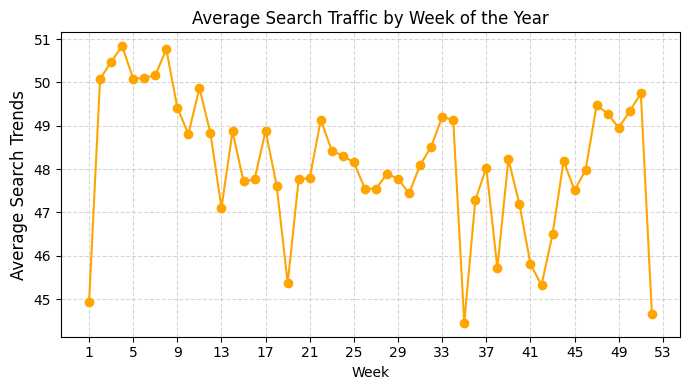

In [29]:
# Group the hourly search data to plot the average traffic by the week of the year using `df.index.isocalendar().week`.
# Group the hourly search data to plot the average traffic by the week of the year using `df.index.isocalendar().week`.
weekly_average_traffic = df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().week).mean()

# Plot the average search traffic by week of the year
plt.figure(figsize=(7, 4))
plt.plot(weekly_average_traffic.index, weekly_average_traffic['Search Trends'], marker='o', linestyle='-', color='orange')
plt.title('Average Search Traffic by Week of the Year', fontsize=12)
plt.xlabel('Week', fontsize=10)
plt.ylabel('Average Search Trends', fontsize=12)
plt.xticks(np.arange(1, 54, 4))  # Set x-axis ticks for every 4 weeks
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

##### Answer the following question:

**Question:** Are there any time based trends that you can see in the data?

**Answer:** There time based trends in the data. Descriptively, people browse MercadoLibre more at night and during the first days of the week. In addition, people browse MercadoLibre early in the year potentially due to New Year Sales and Promotions. There is a drop in week 34-37 as people return from vacations and focus on routines. Lastly, there is a late-year increase explained by seasonal sales.

## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

To do so, complete the following steps:

1. Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

2. Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

3. Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

    * “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

    * “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis

4. Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?


#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [30]:
# Upload the "mercado_stock_price.csv" file into Colab, then store in a Pandas DataFrame
# Set the "date" column as the Datetime Index.
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True
).dropna()

# View the first and last five rows of the DataFrame
display(df_mercado_stock.head())
display(df_mercado_stock.tail())

,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


<Axes: title={'center': 'Closing Price of Mercado Stock'}, xlabel='date'>

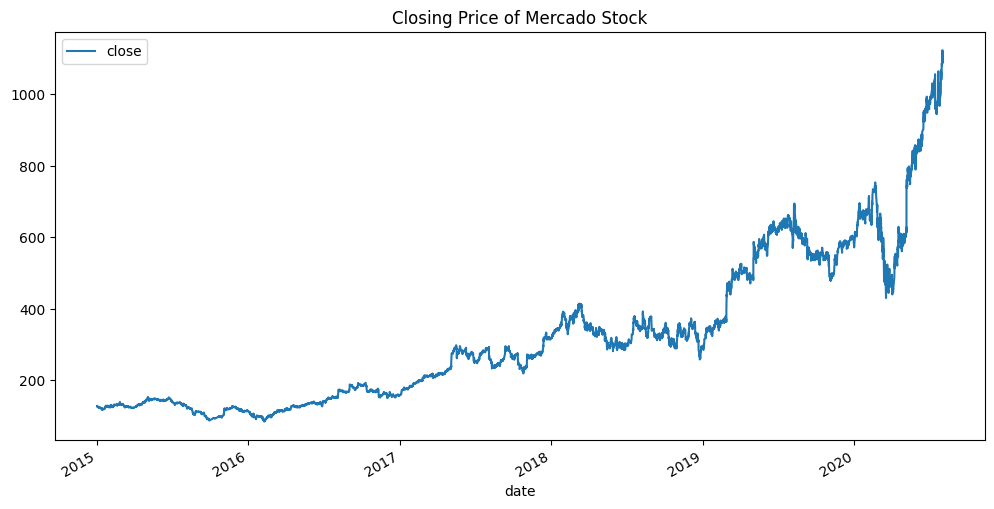

In [31]:
# Visualize the closing price of the df_mercado_stock DataFrame
df_mercado_stock.plot(y='close', title='Closing Price of Mercado Stock', figsize=(12, 6))

In [35]:
# Concatenate the df_mercado_stock DataFrame with the df_mercado_trends DataFrame
# Concatenate the DataFrame by columns (axis=1), and drop and rows with only one column of data
df_mercado_stock_trends = pd.concat([df_mercado_stock, df_mercado_trends], axis=1).dropna()

# View the first and last five rows of the DataFrame
display(df_mercado_stock_trends.head())
display(df_mercado_stock_trends.tail())

,close,Search Trends
2016-06-01 09:00:00,135.16,6.0
2016-06-01 10:00:00,136.63,12.0
2016-06-01 11:00:00,136.56,22.0
2016-06-01 12:00:00,136.42,33.0
2016-06-01 13:00:00,136.10,40.0


,close,Search Trends
2020-07-31 11:00:00,1105.780,20.0
2020-07-31 12:00:00,1087.925,32.0
2020-07-31 13:00:00,1095.800,41.0
2020-07-31 14:00:00,1110.650,47.0
2020-07-31 15:00:00,1122.510,53.0


#### Step 2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

In [36]:
# For the combined dataframe, slice to just the first half of 2020 (2020-01 through 2020-06)
df_mercado_stock_trends = df_mercado_stock_trends.loc['2020-01-01':'2020-06-30']

# View the first and last five rows of first_half_2020 DataFrame
display(df_mercado_stock_trends.head())
display(df_mercado_stock_trends.tail())

,close,Search Trends
2020-01-02 09:00:00,601.085,9.0
2020-01-02 10:00:00,601.290,14.0
2020-01-02 11:00:00,615.410,25.0
2020-01-02 12:00:00,611.400,37.0
2020-01-02 13:00:00,611.830,50.0


,close,Search Trends
2020-06-30 11:00:00,976.17,17.0
2020-06-30 12:00:00,977.50,27.0
2020-06-30 13:00:00,973.23,37.0
2020-06-30 14:00:00,976.50,45.0
2020-06-30 15:00:00,984.93,51.0


array([<Axes: >, <Axes: >], dtype=object)

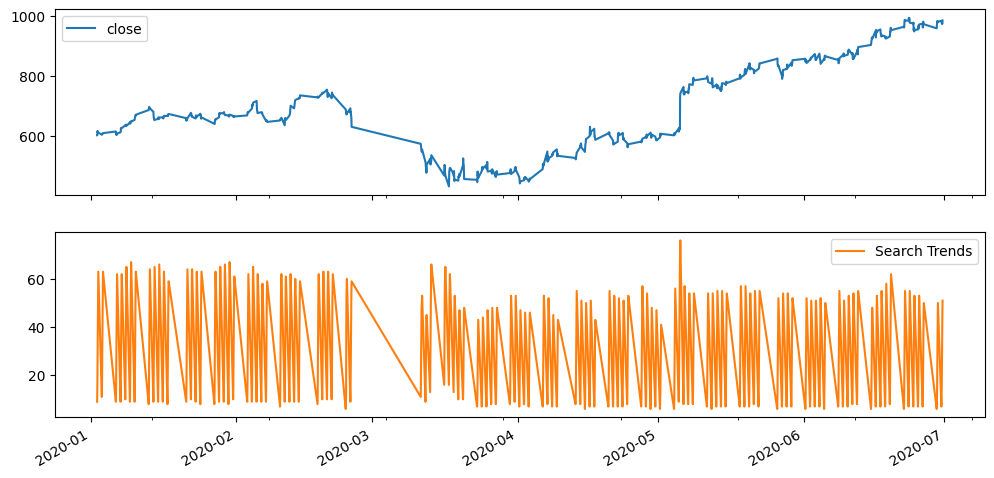

In [38]:
# Visualize the close and Search Trends data
# Plot each column on a separate axes using the following syntax
# `plot(subplots=True)`
df_mercado_stock_trends.plot(subplots=True, figsize=(12, 6))

##### Answer the following question:

**Question:** Do both time series indicate a common trend that’s consistent with this narrative?

**Answer:** Only for the stock price time series. For the search trends time series, it appears to have a disruption in the months of February and March, but after that, the searches were not very different.

#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [39]:
# Create a new column in the mercado_stock_trends_df DataFrame called Lagged Search Trends
# This column should shift the Search Trends information by one hour
df_mercado_stock_trends['Lagged Search Trends'] = df_mercado_stock_trends['Search Trends'].shift(1)
df_mercado_stock_trends.head()


,close,Search Trends,Lagged Search Trends
2020-01-02 09:00:00,601.085,9.0,NaN
2020-01-02 10:00:00,601.290,14.0,9.0
2020-01-02 11:00:00,615.410,25.0,14.0
2020-01-02 12:00:00,611.400,37.0,25.0
2020-01-02 13:00:00,611.830,50.0,37.0


In [40]:
# Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window
df_mercado_stock_trends['Stock Volatility'] = df_mercado_stock_trends['close'].rolling(window=4).std()
df_mercado_stock_trends.head()


,close,Search Trends,Lagged Search Trends,Stock Volatility
2020-01-02 09:00:00,601.085,9.0,NaN,NaN
2020-01-02 10:00:00,601.290,14.0,9.0,NaN
2020-01-02 11:00:00,615.410,25.0,14.0,NaN
2020-01-02 12:00:00,611.400,37.0,25.0,7.241739
2020-01-02 13:00:00,611.830,50.0,37.0,6.067396


<Axes: title={'center': 'Stock Volatility'}>

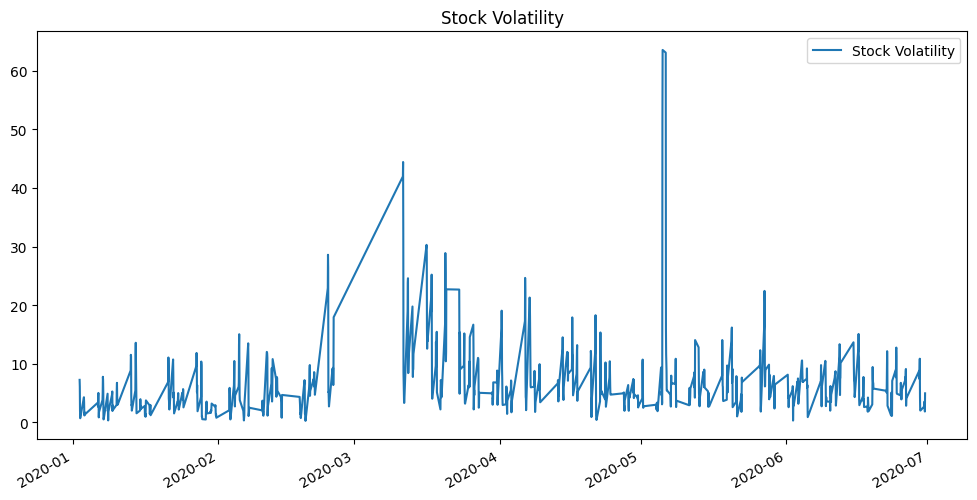

In [41]:
# Visualize the stock volatility
df_mercado_stock_trends.plot(y='Stock Volatility', title='Stock Volatility', figsize=(12, 6))


**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [43]:
# Create a new column in the mercado_stock_trends_df DataFrame called Hourly Stock Return
# This column should calculate hourly return percentage of the closing price
df_mercado_stock_trends['Hourly Stock Return'] = df_mercado_stock_trends['close'].pct_change()


In [45]:
# View the first and last five rows of the mercado_stock_trends_df DataFrame
display(df_mercado_stock_trends.head())
display(df_mercado_stock_trends.tail())

,close,Search Trends,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2020-01-02 09:00:00,601.085,9.0,NaN,NaN,NaN
2020-01-02 10:00:00,601.290,14.0,9.0,NaN,0.000341
2020-01-02 11:00:00,615.410,25.0,14.0,NaN,0.023483
2020-01-02 12:00:00,611.400,37.0,25.0,7.241739,-0.006516
2020-01-02 13:00:00,611.830,50.0,37.0,6.067396,0.000703


,close,Search Trends,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2020-06-30 11:00:00,976.17,17.0,11.0,3.382228,-0.002656
2020-06-30 12:00:00,977.50,27.0,17.0,3.528469,0.001362
2020-06-30 13:00:00,973.23,37.0,27.0,2.375393,-0.004368
2020-06-30 14:00:00,976.50,45.0,37.0,1.835919,0.003360
2020-06-30 15:00:00,984.93,51.0,45.0,4.942044,0.008633


#### Step 4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

In [47]:
# Construct correlation table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return
df_mercado_stock_trends[['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']].corr()

,Stock Volatility,Lagged Search Trends,Hourly Stock Return
Stock Volatility,1.000000,-0.105609,0.034082
Lagged Search Trends,-0.105609,1.000000,-0.003399
Hourly Stock Return,0.034082,-0.003399,1.000000


##### Answer the following question:


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:** There is no predictable relationship between the variables.

## Step 4: Create a Time Series Model with Prophet

Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data. To do so, complete the following steps:

1. Set up the Google search data for a Prophet forecasting model.

2. After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

3. Plot the individual time series components of the model to answer the following questions:

    * What time of day exhibits the greatest popularity?

    * Which day of the week gets the most search traffic?

    * What's the lowest point for search traffic in the calendar year?


#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [48]:
# Using the df_mercado_trends DataFrame, reset the index so the date information is no longer the index
df_mercado_trends = df_mercado_trends.reset_index()

# Label the columns ds and y so that the syntax is recognized by Prophet
df_mercado_trends.columns = ['ds', 'y']

# Drop an NaN values from the prophet_df DataFrame
df_mercado_trends = df_mercado_trends.dropna()

# View the first and last five rows of the mercado_prophet_df DataFrame
display(df_mercado_trends.head())
display(df_mercado_trends.tail())

,ds,y
0,2016-06-01 00:00:00,97
1,2016-06-01 01:00:00,92
2,2016-06-01 02:00:00,76
3,2016-06-01 03:00:00,60
4,2016-06-01 04:00:00,38


,ds,y
37101,2020-09-07 20:00:00,71
37102,2020-09-07 21:00:00,83
37103,2020-09-07 22:00:00,96
37104,2020-09-07 23:00:00,97
37105,2020-09-08 00:00:00,96


In [49]:
# Call the Prophet function, store as an object
prophet_model = Prophet()

In [50]:
# Fit the time-series model.
prophet_model.fit(df_mercado_trends)

DEBUG:cmdstanpy:input tempfile: /tmp/tmph1scd93d/uqkwijs2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph1scd93d/z9bkc3ah.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76134', 'data', 'file=/tmp/tmph1scd93d/uqkwijs2.json', 'init=/tmp/tmph1scd93d/z9bkc3ah.json', 'output', 'file=/tmp/tmph1scd93d/prophet_modeli0r9iaqf/prophet_model-20250127220655.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:07:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [52]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 2000 hours (approx 80 days)
df_mercado_trends_future = prophet_model.make_future_dataframe(periods=2000, freq='h')

# View the last five rows of the future_mercado_trends DataFrame
df_mercado_trends_future.tail()

,ds
39101,2020-11-30 04:00:00
39102,2020-11-30 05:00:00
39103,2020-11-30 06:00:00
39104,2020-11-30 07:00:00
39105,2020-11-30 08:00:00


In [53]:
# Make the predictions for the trend data using the future_mercado_trends DataFrame
df_mercado_trends_future = prophet_model.predict(df_mercado_trends_future)

# Display the first five rows of the forecast_mercado_trends DataFrame
display(df_mercado_trends_future.head())

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-06-01 00:00:00,44.469500,81.397050,97.776255,44.469500,44.469500,45.159722,45.159722,45.159722,41.452703,...,1.860594,1.860594,1.860594,1.846426,1.846426,1.846426,0.0,0.0,0.0,89.629222
1,2016-06-01 01:00:00,44.470406,77.742464,94.062490,44.470406,44.470406,41.605529,41.605529,41.605529,37.943556,...,1.810498,1.810498,1.810498,1.851474,1.851474,1.851474,0.0,0.0,0.0,86.075935
2,2016-06-01 02:00:00,44.471312,67.470179,84.277267,44.471312,44.471312,31.282049,31.282049,31.282049,27.656646,...,1.768912,1.768912,1.768912,1.856491,1.856491,1.856491,0.0,0.0,0.0,75.753361
3,2016-06-01 03:00:00,44.472218,51.915966,69.153761,44.472218,44.472218,16.014826,16.014826,16.014826,12.417424,...,1.735926,1.735926,1.735926,1.861476,1.861476,1.861476,0.0,0.0,0.0,60.487045
4,2016-06-01 04:00:00,44.473124,34.706810,52.047212,44.473124,44.473124,-1.100073,-1.100073,-1.100073,-4.677999,...,1.711496,1.711496,1.711496,1.866430,1.866430,1.866430,0.0,0.0,0.0,43.373051


#### Step 2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

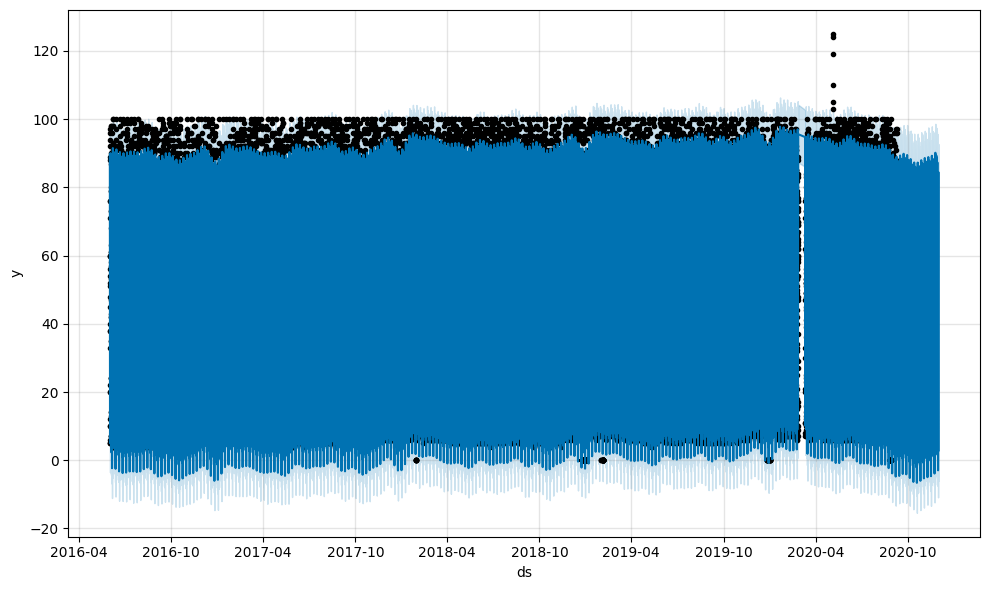

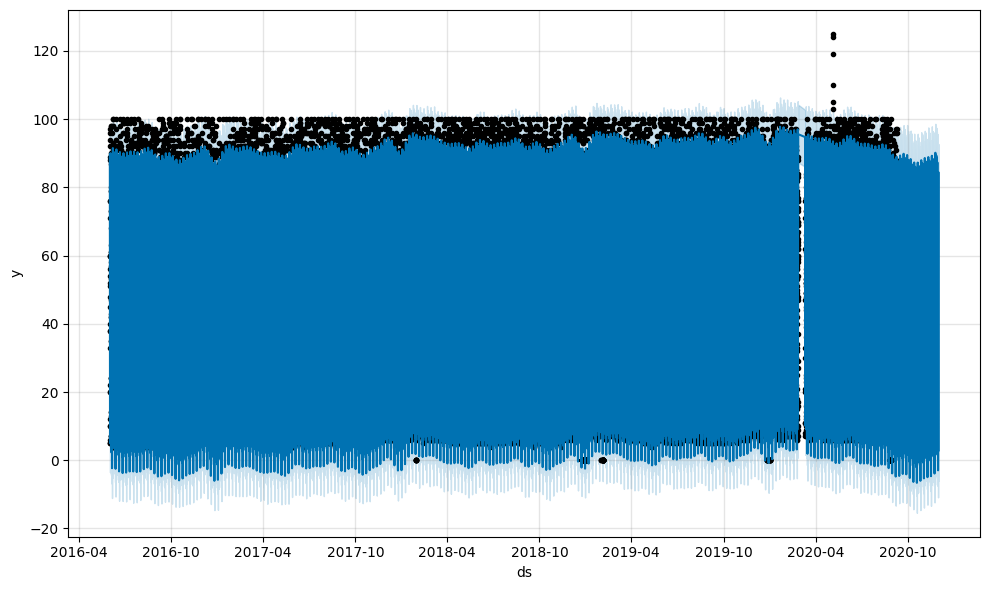

In [56]:
# Plot the Prophet predictions for the Mercado trends data
prophet_model.plot(df_mercado_trends_future)

##### Answer the following question:

**Question:**  How's the near-term forecast for the popularity of MercadoLibre?

**Answer:**


#### Step 3: Plot the individual time series components of the model to answer the following questions:

* What time of day exhibits the greatest popularity?

* Which day of the week gets the most search traffic?

* What's the lowest point for search traffic in the calendar year?


In [ ]:
# Set the index in the forecast_mercado_trends DataFrame to the ds datetime column
df_mercado_trends_future = df_mercado_trends_future.set_index('ds')

# View the only the yhat,yhat_lower and yhat_upper columns from the DataFrame
df_mercado_trends_future[['yhat', 'yhat_lower', 'yhat_upper']].head()


,yhat,yhat_lower,yhat_upper
ds,,,
2016-06-01 00:00:00,89.629222,80.657755,98.092527
2016-06-01 01:00:00,86.075935,77.585016,94.403906
2016-06-01 02:00:00,75.753361,67.254855,83.562064
2016-06-01 03:00:00,60.487045,52.594834,69.279039
2016-06-01 04:00:00,43.373051,34.860822,51.829818


Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

<Axes: xlabel='ds'>

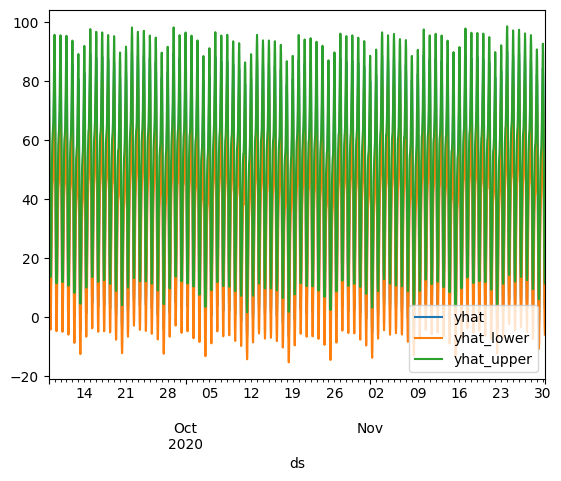

In [59]:
# From the forecast_mercado_trends DataFrame, plot the data to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours
df_mercado_trends_future[['yhat', 'yhat_lower', 'yhat_upper']].tail(2000).plot()


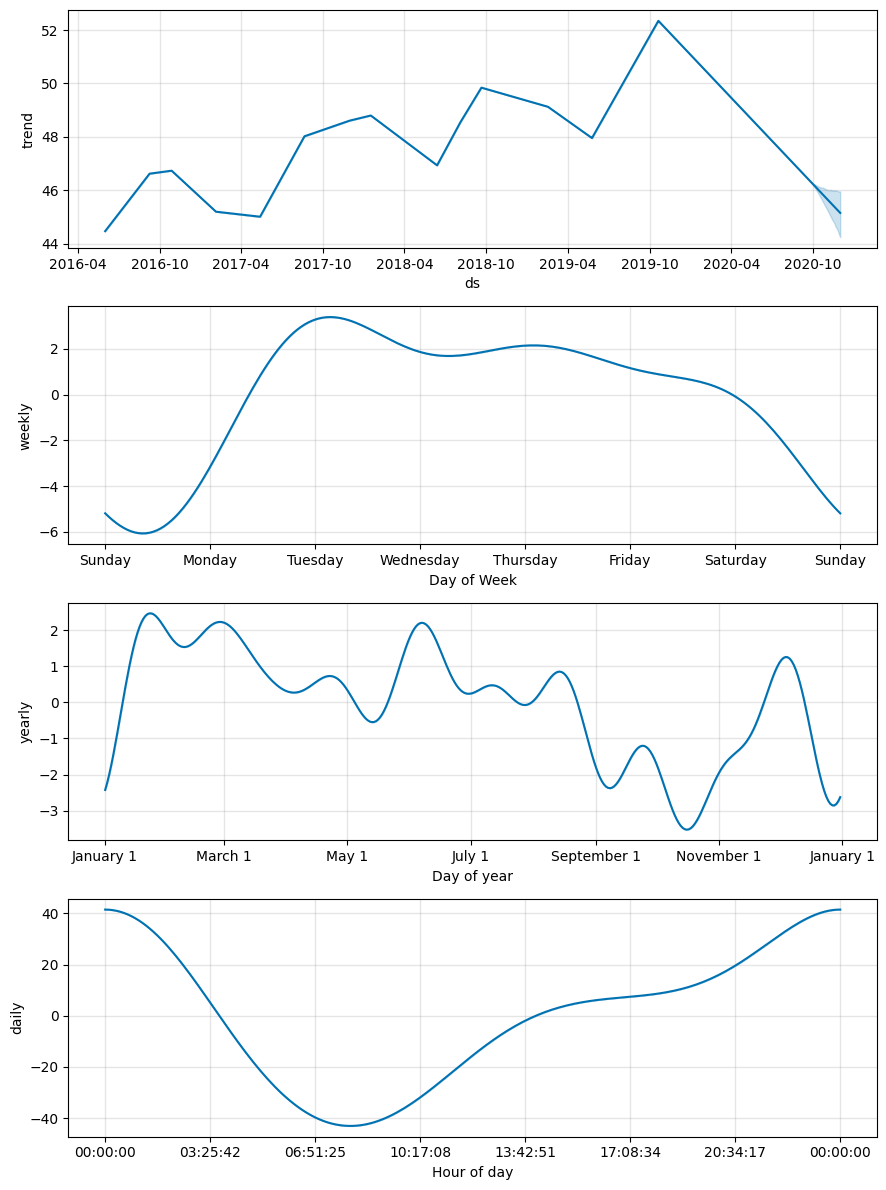

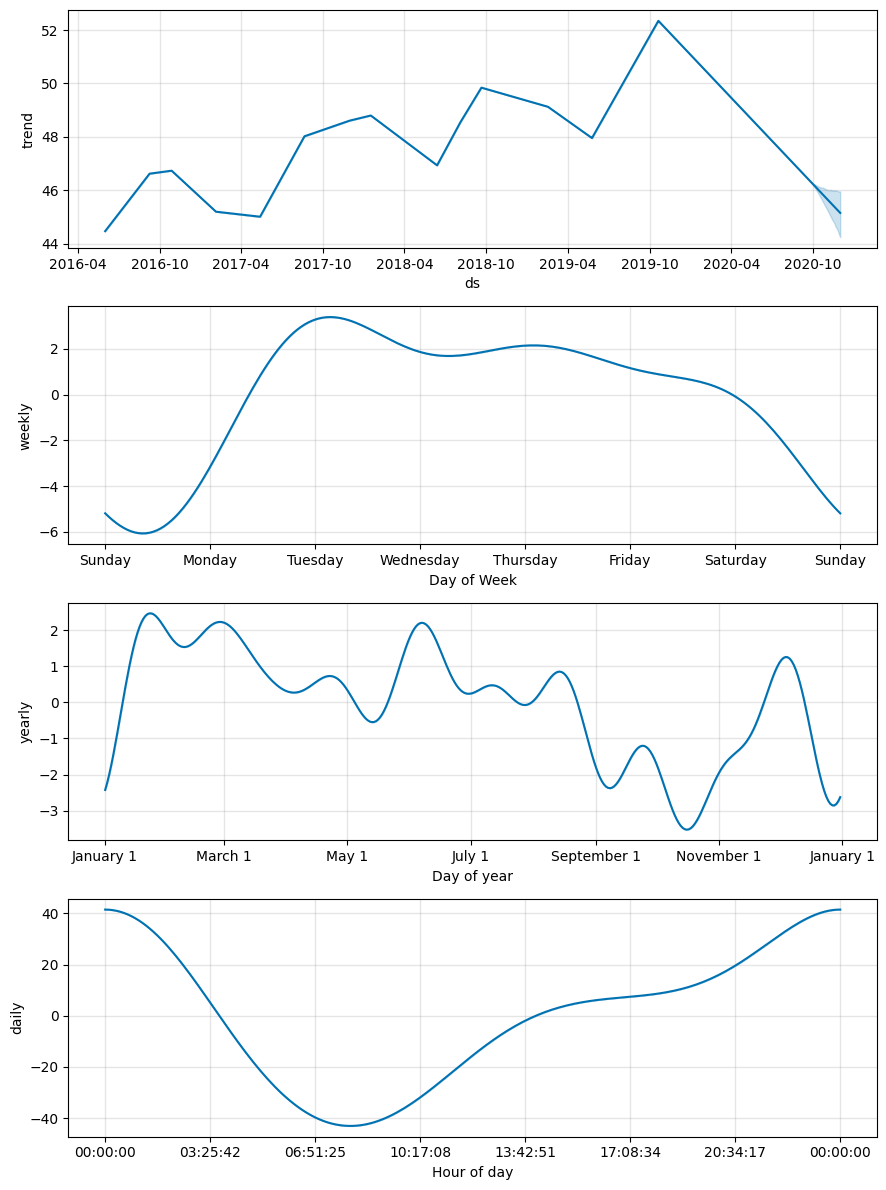

In [60]:
# Reset the index in the forecast_mercado_trends DataFrame
df_mercado_trends_future = df_mercado_trends_future.reset_index()

# Use the plot_components function to visualize the forecast results
# for the forecast_mercado_trends DataFrame
prophet_model.plot_components(df_mercado_trends_future)


##### Answer the following questions:

**Question:** What time of day exhibits the greatest popularity?

**Answer:** Midnight

**Question:** Which day of week gets the most search traffic?
   
**Answer:** Tuesday

**Question:** What's the lowest point for search traffic in the calendar year?

**Answer:** October
